# Predicting Maintenance of Machines

In this project, we will develop an AI-driven predictive maintenance system for manufacturing equipment. By leveraging machine learning models, our application will analyze these inputs to detect failure patterns, forecast potential breakdowns, and inform maintenance schedules.


####Loading the data.

In [1]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

#load data with pandas
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/IT7133/Project/predictive_maintenance_17.csv')

#train test split
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size = 0.4)

Mounted at /content/drive


In [2]:
train_data

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Failure
8152,L,299.5,310.7,1438,45.7,106,0
2701,L,299.9,309.2,1333,50.8,61,0
5399,H,302.8,312.4,1411,53.8,246,1
6386,L,300.2,309.7,1656,34.3,120,0
4221,L,301.9,310.6,1467,39.3,32,0
...,...,...,...,...,...,...,...
8753,M,297.4,308.6,1657,33.1,156,0
7072,M,300.7,310.6,1439,41.7,184,0
7966,L,301.0,312.2,1602,35.9,67,0
6588,L,301.6,310.7,1457,40.4,213,0


#### Data Visualization

#### Histograms for Numeric Features

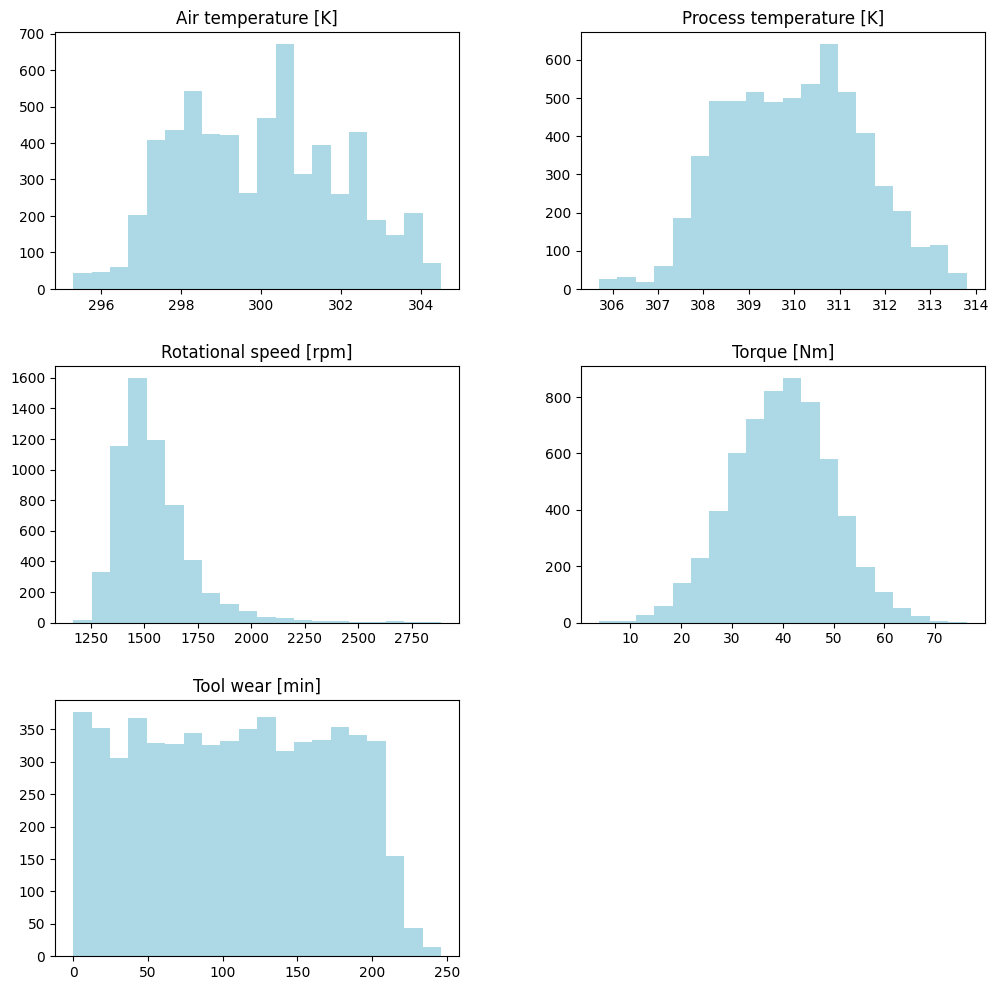

In [3]:
num_cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

import matplotlib.pyplot as plt
train_data[num_cols].hist(bins=20, figsize=(12,12), color='lightblue', grid=False)
plt.show()

#### Bar Charts for Categorical Features

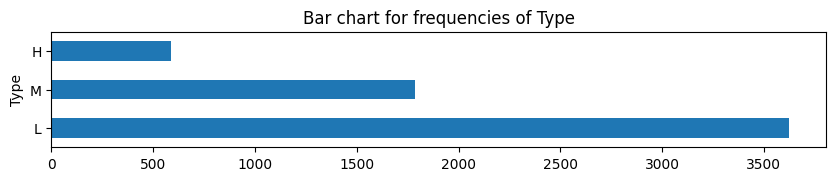

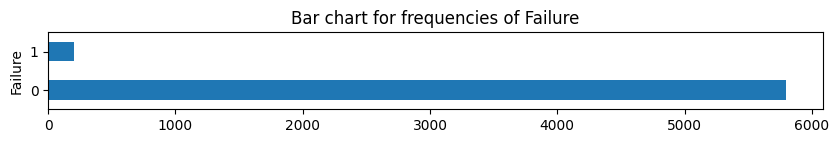

In [4]:
cat_cols = ['Type', 'Failure']
for col in cat_cols:
    freq_table = train_data[col].value_counts()
    plt.figure(figsize = (10,len(freq_table)*0.5))
    freq_table.plot.barh(title='Bar chart for frequencies of ' + col)
    plt.show()
    print()

#### Data Pipeline

In [5]:
num_cols = ['Air temperature [K]', 'Process temperature [K]', 'Torque [Nm]']    #this list is for symmetric numeric columns
log_cols = ['Rotational speed [rpm]', 'Tool wear [min]']                        #this list is for skewed numeric columns
cat_cols = ['Type']                                                             #this list for the class columns
target = ['Failure']                                                            #this is the name of the target

In [6]:
#processing pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),   #impute missing values using column medians
    ('standardize', StandardScaler())               #scale all numeric columns
])

def log_transformation(x):
    return np.log(x + 1)

log_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),                #impute missing values using column medians
    ('log transform', FunctionTransformer(log_transformation)),  #include a log transformation into the pipeline
    ('standardize', StandardScaler())                            #scale all numeric columns
])

processing_pipeline = ColumnTransformer([                                                      #transformer to merge the processed numeric columns and class columns
    ('numeric', num_pipeline, num_cols),                                                       #numeric columns
    ('log', log_pipeline, log_cols),                                                           #log columns
    ('class', OneHotEncoder(max_categories=5, handle_unknown='infrequent_if_exist'), cat_cols) #encoder to transform class columns to numeric, automatically handle missing data
  ])

processing_pipeline.fit(train_data)                            #train the pipeline
trainX = processing_pipeline.transform(train_data)             #generate the training features
trainY = train_data[target]                                    #generate the training target
testX = processing_pipeline.transform(test_data)               #generate the testing features
testY = test_data[target]                                      #generate the testing features

#### Save the processing pipeline

Saving the processing pipeline to use later in the application

In [7]:
import joblib

joblib.dump(processing_pipeline, '/content/drive/MyDrive/IT7133/Project/process_pipeline.pk')

['/content/drive/MyDrive/IT7133/Project/process_pipeline.pk']

#### Model Training

Now, we will build a Neural Network to learn the function between all inputs and machine failure.

In [8]:
num_layers = 5
num_iters = 50
learning_rate = 0.001

In [9]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Input

neural_net = Sequential()
neural_net.add(Input(shape=(trainX.shape[1], )))
for _ in range(num_layers):
  neural_net.add(Dense(trainX.shape[1], activation='relu'))
neural_net.add(Dense(1))

neural_net.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse')
neural_net.fit(trainX, trainY, epochs=num_iters, batch_size=int(trainX.shape[0]//10), validation_split=0.2)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0382 - val_loss: 0.0346
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0324 - val_loss: 0.0327
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0305 - val_loss: 0.0315
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0323 - val_loss: 0.0307
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0310 - val_loss: 0.0300
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0314 - val_loss: 0.0294
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0307 - val_loss: 0.0289
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0274 - val_loss: 0.0285
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0299 - val_loss: 0.0280
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0301 - val_loss: 0.0277
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0282 - val_loss: 0.0274
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0268 - val_loss: 0.0270
Epoch 13/50


In [10]:
neural_net.evaluate(testX, testY)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0284


0.02471841685473919

#### Save the model to use in the application.

In [11]:
neural_net.save('/content/drive/MyDrive/IT7133/Project/predictive_maintenance_NN.keras')